In [10]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import pickle
from matplotlib import pyplot as plt
import lightgbm as lgb
from functools import reduce
from sklearn.metrics import mean_absolute_error
import optuna

* 导入数据

In [11]:
root_path = '../Enefit_RawData/'
train = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'])

# define some funtions
def split_date(data: DataFrame, col: str):
    """
    拆分时间
    :param data:需要拆分的数据
    :param col: 时间所在的列
    :return: DataFrame
    """
    data['year'] = data[col].apply(lambda x: x.year)
    data['month'] = data[col].apply(lambda x: x.month)
    data['day'] = data[col].apply(lambda x: x.day)
    data['hour'] = data[col].apply(lambda x: x.hour)
    return data

def structure_time(data, date_col, target_col, day):
    """构造时间位移函数"""
    data_new = data.copy()
    data_new[date_col] = data_new[date_col] + pd.Timedelta(day, 'D')
    data_new.rename(columns={target_col: target_col+'_'+str(day)}, inplace=True)
    return data_new


def merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station):
    """处理train数据"""
    if 'datetime' in train.columns:
        pass
    else:
        train.rename(columns={'prediction_datetime': 'datetime'}, inplace=True)
    train = split_date(train, 'datetime')  # 拆分时间

    """构造target 2、3、4、5、6、7、14天数据"""
    target2 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 2)
    target3 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 3)
    target4 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 4)
    target5 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 5)
    target6 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 6)
    target7 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 7)
    target14 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                              'datetime', 'target', 14)

    """构造target过去第2天的均值，按county取平均"""
    target_mean = target2.groupby(by=['datetime', 'is_business', 'product_type', 'is_consumption']).mean()['target_2']
    target_mean.rename('target_mean', inplace=True)

    """处理client数据"""
    client['datetime'] = client['date'].apply(lambda x: x+pd.Timedelta(2, 'D'))  # 将day向前移两天
    client = split_date(client, 'datetime')
    client.drop(columns=['hour', 'datetime', 'date'], inplace=True)

    """处理gas_prices数据"""
    gas_prices['datetime'] = gas_prices['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    gas_prices = split_date(gas_prices, 'datetime')
    gas_prices.drop(columns=['datetime', 'forecast_date', 'hour'], inplace=True)

    """处理electricity数据"""
    electricity['datetime'] = electricity['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    electricity.drop(columns=['forecast_date'], inplace=True)

    """处理historical_weather数据"""
    historical_weather['datetime'] = historical_weather['datetime'].apply(lambda x: x + pd.Timedelta(37, 'H'))
    historical_weather['latitude'] = historical_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    historical_weather['longitude'] = historical_weather['longitude'].astype(float)
    historical_weather.loc[:, 'latitude'] = historical_weather.loc[:, 'latitude'].round(1)   # 将经纬度取一位小数
    historical_weather.loc[:, 'longitude'] = historical_weather.loc[:, 'longitude'].round(1)
    station['latitude'] = station['latitude'].astype(float)
    station['longitude'] = station['longitude'].astype(float)
    station.loc[:, 'longitude'] = station.loc[:, 'longitude'].round(1)
    station.loc[:, 'latitude'] = station.loc[:, 'latitude'].round(1)
    # 与station数据按照经纬度和时间拼接
    historical_weather = pd.merge(left=historical_weather, right=station, how='left', on=['latitude', 'longitude'])
    # historical_weather.dropna(subset='county', inplace=True)
    historical_weather.drop(columns=['latitude', 'longitude'], inplace=True)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    historical_weather_local = historical_weather.groupby(by=['datetime', 'county']).mean()

    """构造全局天气均值"""
    historical_weather_date = historical_weather[['datetime', 'temperature', 'dewpoint', 'snowfall', 'cloudcover_total',
                                                  'cloudcover_low', 'shortwave_radiation', 'direct_solar_radiation',
                                                  'diffuse_radiation']].groupby(by=['datetime']).mean()
    col_new = {}
    for col in historical_weather_date.columns:
        col_new[col] = col + '_global'
    historical_weather_date.rename(columns=col_new, inplace=True)

    """处理forecast_weather数据"""
    forecast_weather = forecast_weather[forecast_weather['hours_ahead'] >= 24]
    forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)
    forecast_weather.loc[:, 'longitude'] = forecast_weather.loc[:, 'longitude'].round(1)
    forecast_weather.loc[:, 'latitude'] = forecast_weather.loc[:, 'latitude'].round(1)
    forecast_weather = pd.merge(left=forecast_weather, right=station, on=['latitude', 'longitude'])
    # 去除缺失值以及删除无用列
    # forecast_weather.dropna(subset='county', inplace=True)
    forecast_weather.drop(
        columns=['latitude', 'longitude', 'hours_ahead'],
        inplace=True)
    # 将forecast列索引重命名，以防止合并后与historical重名
    forecast_cols_new = {}
    forecast_cols = forecast_weather.columns
    for index in forecast_cols:
        if index == 'forecast_datetime':
            index_new = 'datetime'
        elif index == 'county':
            index_new = index
        else:
            index_new = str(index) + '_fw'
        forecast_cols_new[index] = index_new
    forecast_weather.rename(columns=forecast_cols_new, inplace=True)
    # 去除时间UTC值
    forecast_weather['datetime'] = pd.to_datetime(forecast_weather.datetime).dt.tz_localize(None)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    forecast_weather = forecast_weather.groupby(by=['datetime', 'county']).mean()

    """开始拼接数据"""
    data = reduce(lambda left, right: pd.merge(left, right, how='left',
                  on=['datetime', 'county', 'is_business', 'product_type', 'is_consumption']),
                  [train, target2, target3, target4, target5, target6, target7, target14])
    data = pd.merge(left=data, right=target_mean, how='left', on=['datetime', 'is_business',
                                                                  'product_type', 'is_consumption'])
    data = pd.merge(left=data, right=client, how='left', on=['product_type', 'county',
                                                             'is_business', 'year', 'month', 'day'])
    data = pd.merge(left=data, right=gas_prices, how='left', on=['year', 'month', 'day'])
    data = pd.merge(left=data, right=electricity, how='left', on='datetime')
    data = pd.merge(left=data, right=historical_weather_local, how='left', on=['datetime', 'county'])
    data = pd.merge(left=data, right=historical_weather_date, how='left', on=['datetime'])
    data = pd.merge(left=data, right=forecast_weather, how='left', on=['datetime', 'county'])

    return data

def load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station, is_train=True):
    """加载数据"""
    data = merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station)
    # 删除多余列
    data.drop(columns=['datetime'], inplace=True)
    # one-hot编码
    data = pd.get_dummies(data, columns=['is_business', 'product_type', 'is_consumption'], dtype=float)
    # 生成nparray数组
    if is_train:
        # 删除缺失值
        data.dropna(subset=['target'], inplace=True)
        X = data.drop(columns=['row_id', 'target'])
        features = list(X.columns)
        X = np.array(X)
        Y = data['target']
        Y = np.array(Y)
        output = (features, X, Y)
        with open("train_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    else:
        X = data.drop(columns=['row_id'])
        X = np.array(X)
        output = X
        with open("test_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    return output

def make_train_test(X, Y, seed, rate):
    """划分训练集和测试集，并且打乱"""
    idx = int(rate * X.shape[0])
    X_train = X[:idx]
    Y_train = Y[:idx]
    X_test = X[idx:]
    Y_test = Y[idx:]
    shuffled_indices = np.arange(X_train.shape[0])
    np.random.seed(seed)
    np.random.shuffle(shuffled_indices)
    X_train, Y_train = X_train[shuffled_indices], Y_train[shuffled_indices]
    return (X_train, Y_train), (X_test, Y_test)

# 未筛选特征所用到的列
train_cols = ['county', 'target', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
test_cols = ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_datetime', 'row_id']
train_history_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
station_cols = ['longitude', 'latitude', 'county']

# 生成未筛选训练数据
train = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'], usecols=train_cols)
train_history = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'], usecols=train_history_cols)
client = pd.read_csv(os.path.join(root_path, 'client.csv'), parse_dates=['date'], usecols=client_cols)
gas_prices = pd.read_csv(os.path.join(root_path, 'gas_prices.csv'), parse_dates=['forecast_date'], usecols=gas_cols)
electricity = pd.read_csv(os.path.join(root_path, 'electricity_prices.csv'), parse_dates=['forecast_date'], usecols=electricity_cols)
historical_weather = pd.read_csv(os.path.join(root_path, 'historical_weather.csv'), parse_dates=['datetime'],
                                     usecols=historical_cols)
forecast_weather = pd.read_csv(os.path.join(root_path, 'forecast_weather.csv'), parse_dates=['forecast_datetime'],
                                   usecols=forecast_cols)
station = pd.read_csv(os.path.join(root_path, 'weather_station_to_county_mapping.csv'), usecols=station_cols)
features, X, Y = load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station)
# 划分训练集和测试集
(X_train_7, y_train_7), (X_test_3, y_test_3) = make_train_test(X, Y, 1, 0.7)
print('features:', features)

C:\Users\Zhang Yingtan\AppData\Local\Temp\ipykernel_16032\988053632.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
C:\Users\Zhang Yingtan\AppData\Local\Temp\ipykernel_16032\988053632.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)
C:\Users\Zhang Yingtan\AppData\Local\Temp\ipykernel_16032\988053632.py:98: SettingWithCopy

features: ['county', 'year', 'month', 'day', 'hour', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_14', 'target_mean', 'eic_count', 'installed_capacity', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'temperature_global', 'dewpoint_global', 'snowfall_global', 'cloudcover_total_global', 'cloudcover_low_global', 'shortwave_radiation_global', 'direct_solar_radiation_global', 'diffuse_radiation_global', 'temperature_fw', 'dewpoint_fw', 'cloudcover_high_fw', 'cloudcover_low_fw', 'cloudcover_mid_fw', 'cloudcover_total_fw', '10_metre_u_wind_component_fw', '10_metre_v_wind_component_fw', 'direct_solar_radiation_fw', 'surface_solar_radiation_downwards_fw', 'snowfall_fw', 'total_precipitation_fw',

* 未调参LightGBM模型结果

mean_absolute_error in test set: 62.159029367786246


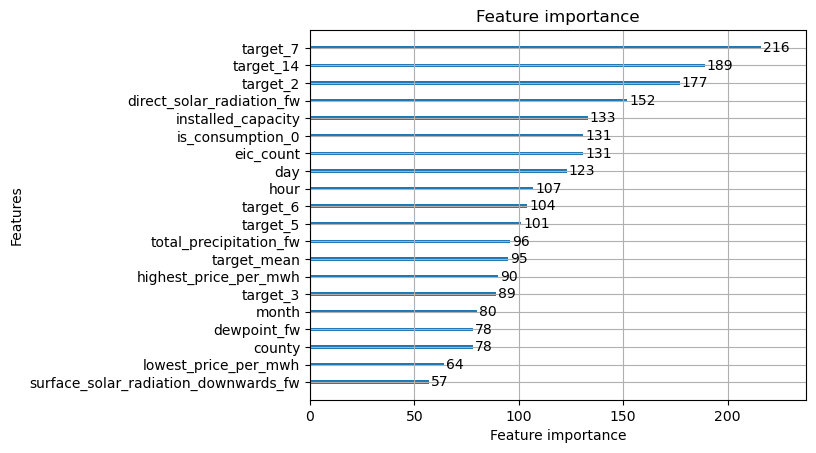

In [12]:
class LightGBM:
    def __init__(self):
        self.model = lgb.LGBMRegressor(objective='regression', n_estimators=100, verbose=0)

    def fit(self, X_train, y_train, X_test, y_test, features):
        self.model.fit(X_train, y_train, feature_name=features)
        y_pred = self.model.predict(X_test)
        print("mean_absolute_error in test set:", mean_absolute_error(y_pred, y_test))
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        return y_pred

    def importance(self, max_num):
        lgb.plot_importance(self.model, max_num_features=max_num)
        plt.show()

model = LightGBM()
model.fit(X_train_7, y_train_7, X_test_3, y_test_3, features)
model.importance(max_num=20)

### 损失函数与评估函数
* 考察五种目标函数和五种评估函数

In [13]:
# 为设置早停 改训练集比测试集7：3 为 训练集比验证集比测试集6：2：2
(X_trainval_8, y_trainval_8), (X_test_2, y_test_2) = make_train_test(X, Y, 1, 0.8)
(X_train_6, y_train_6), (X_val_2, y_val_2) = make_train_test(X_trainval_8, y_trainval_8, 1, 0.75)

In [14]:
mae_test_data=pd.DataFrame(columns=['objectives','metrics','mae'])
objectives=['regression_l1','regression_l2','quantile','poisson','mape']
metrics=['mae','l2','quantile','poisson','mape']
callbacks = [
    lgb.early_stopping(stopping_rounds=10,verbose=True),
    lgb.log_evaluation(period=10,show_stdv=True)
]
for objective in objectives:
    for metric in metrics:
        model = lgb.LGBMRegressor(n_estimators=100, objective=objective, n_jobs=-1, verbose=0)
        model.fit(
            X_train_6, y_train_6,
            eval_set=(X_val_2, y_val_2),
            eval_metric=metric,
            callbacks=callbacks
        )
        y_pred = model.predict(X_test_2)
        size=mae_test_data.size
        mae_test_data.loc[size] = [
            objective, metric,
            mean_absolute_error(y_test_2, y_pred)
        ]
mae_test_data

Training until validation scores don't improve for 10 rounds
[10]	valid_0's l1: 173.006
[20]	valid_0's l1: 127.944
[30]	valid_0's l1: 79.5832
[40]	valid_0's l1: 60.9826
[50]	valid_0's l1: 53.9628
[60]	valid_0's l1: 51.8236
[70]	valid_0's l1: 50.9984
[80]	valid_0's l1: 50.3397
[90]	valid_0's l1: 50.1091
[100]	valid_0's l1: 49.8361
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 49.8361
Training until validation scores don't improve for 10 rounds
[10]	valid_0's l2: 678587	valid_0's l1: 173.006
[20]	valid_0's l2: 526520	valid_0's l1: 127.944
[30]	valid_0's l2: 196739	valid_0's l1: 79.5832
[40]	valid_0's l2: 90461.8	valid_0's l1: 60.9826
[50]	valid_0's l2: 56629.2	valid_0's l1: 53.9628
[60]	valid_0's l2: 46854.6	valid_0's l1: 51.8236
[70]	valid_0's l2: 43697.6	valid_0's l1: 50.9984
[80]	valid_0's l2: 42036.3	valid_0's l1: 50.3397
[90]	valid_0's l2: 41745.8	valid_0's l1: 50.1091
[100]	valid_0's l2: 41278.5	valid_0's l1: 49.8361
Did not meet early stopping. Best iteration

,objectives,metrics,mae
0,regression_l1,mae,73.961919
3,regression_l1,l2,73.961919
6,regression_l1,quantile,73.961919
9,regression_l1,poisson,73.961919
12,regression_l1,mape,74.011020
15,regression_l2,mae,69.092237
18,regression_l2,l2,69.092237
21,regression_l2,quantile,69.092237
24,regression_l2,poisson,69.255253
27,regression_l2,mape,69.144791


* objective选用regression_l2，metric选用l2

### 手动调参（两参数）

In [15]:
# 时序数据由于自相关不是独立同分布，不建议交叉验证
# 因为GridSearchCV必须设定交叉验证，所以就直接for循环了
# num_leaves (int, optional (default=31)) / max_depth (int, optional (default=-1))
maes = []
for num_leaves in range(11,92,10):
    for max_depth in range(7,11,1):
        model=lgb.LGBMRegressor(
            objective='regression_l2',
            num_leaves=num_leaves,
            max_depth=max_depth,
            n_jobs=-1,
            verbose=0,
            verbosity=-1
        )
        model.fit(X_train_7, y_train_7, eval_metric='l2')
        y_pred = model.predict(X_test_3)
        mae = mean_absolute_error(y_test_3, y_pred)
        maes.append(mae)
maes.sort()
maes[0]

60.149270847918345

### Bayes调参

In [16]:
def objective(trial):

    #定义参数空间 10维
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_setimators', [30, 40, 50 ,60, 70, 80, 90, 100]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 91, step=1),
        'num_leaves': trial.suggest_int('num_leaves', 6, 180, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'bagging_freq': trial.suggest_categorical('bagging_freq', [1]),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
        'random_state': 2023,
    }
    
    callbacks = [
    lgb.early_stopping(stopping_rounds=10,verbose=False),
    lgb.log_evaluation(period=10,show_stdv=False)
    ]

    #定义评估器
    model = lgb.LGBMRegressor(
        objective='regression_l2',
        **param_grid,
        n_jobs=-1,
        verbose=0,
        verbosity=-1
    )
    
    # 评估模型表现
    model.fit(
        X_train_6, y_train_6, eval_set=(X_val_2, y_val_2),
        eval_metric='l2', callbacks=callbacks
    )
    y_pred = model.predict(X_test_2)
    mae = mean_absolute_error(y_test_2, y_pred)
    return mae

def optimize(n_trials):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials)
    return study.best_params

In [17]:
param_dic = optimize(100)

[I 2023-12-26 16:30:49,095] A new study created in memory with name: no-name-21b84e15-d888-46a1-a685-7fcaaff90fc6
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 205462
[20]	valid_0's l2: 78381.6
[30]	valid_0's l2: 47941.9


[I 2023-12-26 16:30:51,360] Trial 0 finished with value: 75.56193123456558 and parameters: {'n_setimators': 40, 'learning_rate': 0.07876722266480138, 'max_depth': 27, 'num_leaves': 159, 'min_data_in_leaf': 400, 'lambda_l1': 45, 'lambda_l2': 75, 'min_gain_to_split': 3.1219398425221834, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 75.56193123456558.


[40]	valid_0's l2: 38839.4


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 67367.7
[20]	valid_0's l2: 47335.8
[30]	valid_0's l2: 41973.8
[40]	valid_0's l2: 38873.5


[I 2023-12-26 16:30:54,320] Trial 1 finished with value: 73.57532175137143 and parameters: {'n_setimators': 40, 'learning_rate': 0.18217007671435764, 'max_depth': 84, 'num_leaves': 76, 'min_data_in_leaf': 2800, 'lambda_l1': 85, 'lambda_l2': 20, 'min_gain_to_split': 11.087482500432547, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 73.57532175137143.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 32986
[20]	valid_0's l2: 27354.1


[I 2023-12-26 16:30:56,238] Trial 2 finished with value: 76.79235653783638 and parameters: {'n_setimators': 30, 'learning_rate': 0.29938050355626156, 'max_depth': 15, 'num_leaves': 141, 'min_data_in_leaf': 300, 'lambda_l1': 20, 'lambda_l2': 15, 'min_gain_to_split': 2.328889549270716, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 73.57532175137143.


[30]	valid_0's l2: 24902.3


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 483114
[20]	valid_0's l2: 351146
[30]	valid_0's l2: 276942
[40]	valid_0's l2: 236813
[50]	valid_0's l2: 210487
[60]	valid_0's l2: 191294
[70]	valid_0's l2: 176996
[80]	valid_0's l2: 166491
[90]	valid_0's l2: 158639
[100]	valid_0's l2: 152384


[I 2023-12-26 16:30:58,712] Trial 3 finished with value: 140.45534778201264 and parameters: {'n_setimators': 100, 'learning_rate': 0.039586120334193765, 'max_depth': 19, 'num_leaves': 9, 'min_data_in_leaf': 6700, 'lambda_l1': 30, 'lambda_l2': 40, 'min_gain_to_split': 2.3649286911136587, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 73.57532175137143.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 93740.9
[20]	valid_0's l2: 63432.2
[30]	valid_0's l2: 53890.4


[I 2023-12-26 16:31:01,201] Trial 4 finished with value: 78.43023442492697 and parameters: {'n_setimators': 40, 'learning_rate': 0.15863452417765833, 'max_depth': 9, 'num_leaves': 92, 'min_data_in_leaf': 7700, 'lambda_l1': 65, 'lambda_l2': 30, 'min_gain_to_split': 2.6433527044594656, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 73.57532175137143.


[40]	valid_0's l2: 49321.9


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 44469.5
[20]	valid_0's l2: 30810.4
[30]	valid_0's l2: 28637.9
[40]	valid_0's l2: 27137.7
[50]	valid_0's l2: 26049.1
[60]	valid_0's l2: 24836.2
[70]	valid_0's l2: 24082.1
[80]	valid_0's l2: 23421.8
[90]	valid_0's l2: 22951.6


[I 2023-12-26 16:31:05,611] Trial 5 finished with value: 71.26225516116534 and parameters: {'n_setimators': 90, 'learning_rate': 0.21428425192291067, 'max_depth': 13, 'num_leaves': 129, 'min_data_in_leaf': 1500, 'lambda_l1': 35, 'lambda_l2': 80, 'min_gain_to_split': 1.8527080265502165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 267075
[20]	valid_0's l2: 201384
[30]	valid_0's l2: 163734
[40]	valid_0's l2: 139355
[50]	valid_0's l2: 123398
[60]	valid_0's l2: 112488


[I 2023-12-26 16:31:07,715] Trial 6 finished with value: 168.64518958488017 and parameters: {'n_setimators': 60, 'learning_rate': 0.1866870258279291, 'max_depth': 33, 'num_leaves': 168, 'min_data_in_leaf': 9400, 'lambda_l1': 50, 'lambda_l2': 65, 'min_gain_to_split': 4.393546563911829, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 131910
[20]	valid_0's l2: 70390.3
[30]	valid_0's l2: 59412


[I 2023-12-26 16:31:10,431] Trial 7 finished with value: 77.68567475384866 and parameters: {'n_setimators': 40, 'learning_rate': 0.11731575645077495, 'max_depth': 89, 'num_leaves': 124, 'min_data_in_leaf': 5700, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 13.158328383900622, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 5 with value: 71.26225516116534.


[40]	valid_0's l2: 52810.7


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 55973.7
[20]	valid_0's l2: 42486.2
[30]	valid_0's l2: 38456.5
[40]	valid_0's l2: 36727
[50]	valid_0's l2: 35033.9
[60]	valid_0's l2: 34040
[70]	valid_0's l2: 33313.3
[80]	valid_0's l2: 32639.3
[90]	valid_0's l2: 31893.3


[I 2023-12-26 16:31:15,420] Trial 8 finished with value: 75.84065598513827 and parameters: {'n_setimators': 90, 'learning_rate': 0.23105821544015162, 'max_depth': 80, 'num_leaves': 158, 'min_data_in_leaf': 3100, 'lambda_l1': 100, 'lambda_l2': 35, 'min_gain_to_split': 11.465986595114867, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 57090.1
[20]	valid_0's l2: 37042.4
[30]	valid_0's l2: 34238.8
[40]	valid_0's l2: 32756.1


[I 2023-12-26 16:31:18,021] Trial 9 finished with value: 74.37807304939754 and parameters: {'n_setimators': 40, 'learning_rate': 0.18104262829711767, 'max_depth': 87, 'num_leaves': 96, 'min_data_in_leaf': 1600, 'lambda_l1': 0, 'lambda_l2': 55, 'min_gain_to_split': 9.990126606115764, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 49159.4
[20]	valid_0's l2: 37452.9
[30]	valid_0's l2: 35171.6
[40]	valid_0's l2: 33707.1


[I 2023-12-26 16:31:21,036] Trial 10 finished with value: 74.81916582795596 and parameters: {'n_setimators': 50, 'learning_rate': 0.2672007482400112, 'max_depth': 57, 'num_leaves': 43, 'min_data_in_leaf': 4000, 'lambda_l1': 0, 'lambda_l2': 100, 'min_gain_to_split': 7.205248411906054, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 5 with value: 71.26225516116534.


[50]	valid_0's l2: 32510.3


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 56200.4
[20]	valid_0's l2: 42197.2
[30]	valid_0's l2: 38594.5
[40]	valid_0's l2: 36794.8
[50]	valid_0's l2: 35320
[60]	valid_0's l2: 34435.5
[70]	valid_0's l2: 33695


[I 2023-12-26 16:31:25,933] Trial 11 finished with value: 75.31589174487343 and parameters: {'n_setimators': 70, 'learning_rate': 0.21916331498159913, 'max_depth': 57, 'num_leaves': 78, 'min_data_in_leaf': 2700, 'lambda_l1': 80, 'lambda_l2': 0, 'min_gain_to_split': 7.288687374913803, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 107053
[20]	valid_0's l2: 54364.5
[30]	valid_0's l2: 47159.6
[40]	valid_0's l2: 42513.3
[50]	valid_0's l2: 40310.8
[60]	valid_0's l2: 38862.2
[70]	valid_0's l2: 37594.2
[80]	valid_0's l2: 36671.8
[90]	valid_0's l2: 36001.3


[I 2023-12-26 16:31:32,038] Trial 12 finished with value: 72.8501908031516 and parameters: {'n_setimators': 90, 'learning_rate': 0.12664696305173012, 'max_depth': 44, 'num_leaves': 61, 'min_data_in_leaf': 4200, 'lambda_l1': 75, 'lambda_l2': 90, 'min_gain_to_split': 0.15093379013226338, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 124324
[20]	valid_0's l2: 58235.7
[30]	valid_0's l2: 49033.1
[40]	valid_0's l2: 44452.5
[50]	valid_0's l2: 42021.7
[60]	valid_0's l2: 40552.2
[70]	valid_0's l2: 39062.8
[80]	valid_0's l2: 38135.8
[90]	valid_0's l2: 37476.8


[I 2023-12-26 16:31:36,991] Trial 13 finished with value: 73.6448230917239 and parameters: {'n_setimators': 90, 'learning_rate': 0.11397732483361159, 'max_depth': 42, 'num_leaves': 49, 'min_data_in_leaf': 4800, 'lambda_l1': 65, 'lambda_l2': 95, 'min_gain_to_split': 0.7235540632157976, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 108059
[20]	valid_0's l2: 45748.7
[30]	valid_0's l2: 37755.4
[40]	valid_0's l2: 36007.1
[50]	valid_0's l2: 34916.2
[60]	valid_0's l2: 34264
[70]	valid_0's l2: 33758
[80]	valid_0's l2: 33338.7


[I 2023-12-26 16:31:39,762] Trial 14 finished with value: 76.50755471700661 and parameters: {'n_setimators': 90, 'learning_rate': 0.11785197666695561, 'max_depth': 5, 'num_leaves': 111, 'min_data_in_leaf': 1600, 'lambda_l1': 75, 'lambda_l2': 80, 'min_gain_to_split': 0.3060285078775667, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 5 with value: 71.26225516116534.


[90]	valid_0's l2: 32830.1


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 536901
[20]	valid_0's l2: 396065
[30]	valid_0's l2: 290777
[40]	valid_0's l2: 247353
[50]	valid_0's l2: 183590
[60]	valid_0's l2: 142253
[70]	valid_0's l2: 115984
[80]	valid_0's l2: 96777.2


[I 2023-12-26 16:31:42,647] Trial 15 finished with value: 129.11941380782977 and parameters: {'n_setimators': 80, 'learning_rate': 0.022222430085472977, 'max_depth': 63, 'num_leaves': 56, 'min_data_in_leaf': 4500, 'lambda_l1': 100, 'lambda_l2': 85, 'min_gain_to_split': 5.617180141056318, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 74108.4
[20]	valid_0's l2: 56481.3
[30]	valid_0's l2: 50915.7
[40]	valid_0's l2: 46073.7
[50]	valid_0's l2: 43416.2
[60]	valid_0's l2: 41394.5
[70]	valid_0's l2: 39761.1
[80]	valid_0's l2: 38635.5


[I 2023-12-26 16:31:45,593] Trial 16 finished with value: 80.78198979057542 and parameters: {'n_setimators': 90, 'learning_rate': 0.22656318272052423, 'max_depth': 43, 'num_leaves': 12, 'min_data_in_leaf': 6400, 'lambda_l1': 40, 'lambda_l2': 65, 'min_gain_to_split': 0.15576088604231597, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 5 with value: 71.26225516116534.


[90]	valid_0's l2: 38106.2


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 173743
[20]	valid_0's l2: 70852.9
[30]	valid_0's l2: 50643.9
[40]	valid_0's l2: 44005
[50]	valid_0's l2: 40188.9
[60]	valid_0's l2: 37663.2
[70]	valid_0's l2: 36311.2
[80]	valid_0's l2: 35320.4
[90]	valid_0's l2: 34690.6


[I 2023-12-26 16:31:52,885] Trial 17 finished with value: 71.72459139210963 and parameters: {'n_setimators': 90, 'learning_rate': 0.08833661023905279, 'max_depth': 31, 'num_leaves': 136, 'min_data_in_leaf': 3600, 'lambda_l1': 65, 'lambda_l2': 85, 'min_gain_to_split': 5.075991477845731, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 5 with value: 71.26225516116534.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 230142
[20]	valid_0's l2: 89458
[30]	valid_0's l2: 51362
[40]	valid_0's l2: 40008.2
[50]	valid_0's l2: 35515.5
[60]	valid_0's l2: 33464.3
[70]	valid_0's l2: 32048.9
[80]	valid_0's l2: 31148


[I 2023-12-26 16:31:59,154] Trial 18 finished with value: 70.48947370448982 and parameters: {'n_setimators': 80, 'learning_rate': 0.06745373218556575, 'max_depth': 28, 'num_leaves': 134, 'min_data_in_leaf': 1700, 'lambda_l1': 60, 'lambda_l2': 70, 'min_gain_to_split': 4.6839240643273214, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 358397
[20]	valid_0's l2: 179724
[30]	valid_0's l2: 100787
[40]	valid_0's l2: 65376.7
[50]	valid_0's l2: 49037.7
[60]	valid_0's l2: 41279.5
[70]	valid_0's l2: 37062.2
[80]	valid_0's l2: 34491.9


[I 2023-12-26 16:32:05,007] Trial 19 finished with value: 73.57041001919258 and parameters: {'n_setimators': 80, 'learning_rate': 0.041848762475773904, 'max_depth': 23, 'num_leaves': 180, 'min_data_in_leaf': 1600, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 6.044801960917917, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 214123
[20]	valid_0's l2: 87952
[30]	valid_0's l2: 57823.3
[40]	valid_0's l2: 49839.3
[50]	valid_0's l2: 46888.7
[60]	valid_0's l2: 42473.2
[70]	valid_0's l2: 40420.1
[80]	valid_0's l2: 38843.5


[I 2023-12-26 16:32:08,734] Trial 20 finished with value: 73.05037204329345 and parameters: {'n_setimators': 80, 'learning_rate': 0.07537581993519293, 'max_depth': 14, 'num_leaves': 120, 'min_data_in_leaf': 2100, 'lambda_l1': 35, 'lambda_l2': 50, 'min_gain_to_split': 8.700674225393533, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 183299
[20]	valid_0's l2: 74311.4


[I 2023-12-26 16:32:11,208] Trial 21 finished with value: 85.05852325887278 and parameters: {'n_setimators': 30, 'learning_rate': 0.08457137474093668, 'max_depth': 26, 'num_leaves': 141, 'min_data_in_leaf': 3400, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 4.560511262505405, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 18 with value: 70.48947370448982.


[30]	valid_0's l2: 51723.5


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 316253
[20]	valid_0's l2: 144980
[30]	valid_0's l2: 78341.3
[40]	valid_0's l2: 51695
[50]	valid_0's l2: 40308.4
[60]	valid_0's l2: 35027.3


[I 2023-12-26 16:32:16,043] Trial 22 finished with value: 76.20086668521277 and parameters: {'n_setimators': 60, 'learning_rate': 0.048962799409854874, 'max_depth': 33, 'num_leaves': 140, 'min_data_in_leaf': 1100, 'lambda_l1': 55, 'lambda_l2': 65, 'min_gain_to_split': 3.940823429185001, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 615365
[20]	valid_0's l2: 496405
[30]	valid_0's l2: 402112
[40]	valid_0's l2: 327545
[50]	valid_0's l2: 268224


[I 2023-12-26 16:32:23,386] Trial 23 finished with value: 231.15209764809939 and parameters: {'n_setimators': 50, 'learning_rate': 0.012084214593691384, 'max_depth': 34, 'num_leaves': 130, 'min_data_in_leaf': 2300, 'lambda_l1': 55, 'lambda_l2': 85, 'min_gain_to_split': 5.713290780689805, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 81799.2
[20]	valid_0's l2: 49075.4
[30]	valid_0's l2: 42232.8
[40]	valid_0's l2: 40277.8
[50]	valid_0's l2: 39068.8
[60]	valid_0's l2: 38404
[70]	valid_0's l2: 37652.8
[80]	valid_0's l2: 37109.2
[90]	valid_0's l2: 36318.5
[100]	valid_0's l2: 35840.6


[I 2023-12-26 16:32:31,200] Trial 24 finished with value: 79.3935470815541 and parameters: {'n_setimators': 100, 'learning_rate': 0.1536799576952434, 'max_depth': 3, 'num_leaves': 107, 'min_data_in_leaf': 3600, 'lambda_l1': 60, 'lambda_l2': 70, 'min_gain_to_split': 1.652509513293314, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 18 with value: 70.48947370448982.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 153303
[20]	valid_0's l2: 54147.7
[30]	valid_0's l2: 35136.3
[40]	valid_0's l2: 29834.3
[50]	valid_0's l2: 26953.1
[60]	valid_0's l2: 25442.9
[70]	valid_0's l2: 24587.9


[I 2023-12-26 16:32:44,325] Trial 25 finished with value: 68.27228461101608 and parameters: {'n_setimators': 70, 'learning_rate': 0.09311578590118827, 'max_depth': 12, 'num_leaves': 149, 'min_data_in_leaf': 700, 'lambda_l1': 90, 'lambda_l2': 100, 'min_gain_to_split': 3.7930918185331093, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 253515
[20]	valid_0's l2: 102598
[30]	valid_0's l2: 56725.8
[40]	valid_0's l2: 41709.1
[50]	valid_0's l2: 35757.5
[60]	valid_0's l2: 32490.1
[70]	valid_0's l2: 30572.2


[I 2023-12-26 16:32:57,503] Trial 26 finished with value: 70.1681052230348 and parameters: {'n_setimators': 70, 'learning_rate': 0.06303387040334246, 'max_depth': 11, 'num_leaves': 153, 'min_data_in_leaf': 900, 'lambda_l1': 85, 'lambda_l2': 100, 'min_gain_to_split': 3.6886505801831193, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 271898
[20]	valid_0's l2: 113853
[30]	valid_0's l2: 61894.8
[40]	valid_0's l2: 43950.5
[50]	valid_0's l2: 36817.9
[60]	valid_0's l2: 33026
[70]	valid_0's l2: 30799.6


[I 2023-12-26 16:33:11,342] Trial 27 finished with value: 70.79965236614657 and parameters: {'n_setimators': 70, 'learning_rate': 0.05893558667599198, 'max_depth': 20, 'num_leaves': 151, 'min_data_in_leaf': 800, 'lambda_l1': 90, 'lambda_l2': 100, 'min_gain_to_split': 3.5955099739784355, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 150018
[20]	valid_0's l2: 52997.3
[30]	valid_0's l2: 34030.9
[40]	valid_0's l2: 28208.3
[50]	valid_0's l2: 25675.5
[60]	valid_0's l2: 24465.5
[70]	valid_0's l2: 23377.8


[I 2023-12-26 16:33:20,419] Trial 28 finished with value: 70.9633440209439 and parameters: {'n_setimators': 70, 'learning_rate': 0.09524281973797859, 'max_depth': 7, 'num_leaves': 178, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 95, 'min_gain_to_split': 6.35117113284481, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 233179
[20]	valid_0's l2: 91645.3
[30]	valid_0's l2: 53043.3
[40]	valid_0's l2: 41302.2
[50]	valid_0's l2: 36713.3
[60]	valid_0's l2: 34607.4
[70]	valid_0's l2: 33266.8


[I 2023-12-26 16:33:33,549] Trial 29 finished with value: 71.2646092610611 and parameters: {'n_setimators': 70, 'learning_rate': 0.06942781233332335, 'max_depth': 27, 'num_leaves': 154, 'min_data_in_leaf': 900, 'lambda_l1': 90, 'lambda_l2': 100, 'min_gain_to_split': 8.452240618526735, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 85475.3
[20]	valid_0's l2: 40907.6
[30]	valid_0's l2: 35555.1
[40]	valid_0's l2: 34041.5
[50]	valid_0's l2: 33045.4
[60]	valid_0's l2: 32338.8
[70]	valid_0's l2: 31545.2


[I 2023-12-26 16:33:47,131] Trial 30 finished with value: 72.84887699452467 and parameters: {'n_setimators': 70, 'learning_rate': 0.13679596896791754, 'max_depth': 18, 'num_leaves': 166, 'min_data_in_leaf': 2300, 'lambda_l1': 75, 'lambda_l2': 90, 'min_gain_to_split': 3.003599017078, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 288243
[20]	valid_0's l2: 124654
[30]	valid_0's l2: 67603.8
[40]	valid_0's l2: 46513.5
[50]	valid_0's l2: 37924.3
[60]	valid_0's l2: 33711.6
[70]	valid_0's l2: 31124.5


[I 2023-12-26 16:34:01,027] Trial 31 finished with value: 71.01721235940508 and parameters: {'n_setimators': 70, 'learning_rate': 0.05547143418611284, 'max_depth': 20, 'num_leaves': 154, 'min_data_in_leaf': 700, 'lambda_l1': 90, 'lambda_l2': 100, 'min_gain_to_split': 3.4321589638500027, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 251966
[20]	valid_0's l2: 101552
[30]	valid_0's l2: 56440.5
[40]	valid_0's l2: 42018.5
[50]	valid_0's l2: 36560.1
[60]	valid_0's l2: 33530.9
[70]	valid_0's l2: 31954.6


[I 2023-12-26 16:34:14,975] Trial 32 finished with value: 70.73998589675479 and parameters: {'n_setimators': 70, 'learning_rate': 0.06331977467224964, 'max_depth': 13, 'num_leaves': 147, 'min_data_in_leaf': 1100, 'lambda_l1': 95, 'lambda_l2': 95, 'min_gain_to_split': 3.7469875707516977, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 140432
[20]	valid_0's l2: 50196.2
[30]	valid_0's l2: 33125.9
[40]	valid_0's l2: 27451.8
[50]	valid_0's l2: 24901.7
[60]	valid_0's l2: 23511.7
[70]	valid_0's l2: 22346.4


[I 2023-12-26 16:34:26,883] Trial 33 finished with value: 68.8125442822868 and parameters: {'n_setimators': 70, 'learning_rate': 0.10121293639359338, 'max_depth': 11, 'num_leaves': 165, 'min_data_in_leaf': 200, 'lambda_l1': 100, 'lambda_l2': 90, 'min_gain_to_split': 4.771167634886871, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 130341
[20]	valid_0's l2: 48236.3
[30]	valid_0's l2: 34305.3
[40]	valid_0's l2: 29533.6
[50]	valid_0's l2: 27518.5
[60]	valid_0's l2: 26337.7
[70]	valid_0's l2: 25433.1
[80]	valid_0's l2: 24647.2


[I 2023-12-26 16:34:38,581] Trial 34 finished with value: 70.30144064212696 and parameters: {'n_setimators': 80, 'learning_rate': 0.10575481765376239, 'max_depth': 10, 'num_leaves': 170, 'min_data_in_leaf': 400, 'lambda_l1': 80, 'lambda_l2': 75, 'min_gain_to_split': 4.8284569617106445, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 143200
[20]	valid_0's l2: 51380.6
[30]	valid_0's l2: 33902.1
[40]	valid_0's l2: 28252.6
[50]	valid_0's l2: 25284.1
[60]	valid_0's l2: 23842.5
[70]	valid_0's l2: 22750.2


[I 2023-12-26 16:34:46,478] Trial 35 finished with value: 69.86494317173695 and parameters: {'n_setimators': 70, 'learning_rate': 0.1001479096295874, 'max_depth': 11, 'num_leaves': 162, 'min_data_in_leaf': 200, 'lambda_l1': 80, 'lambda_l2': 90, 'min_gain_to_split': 1.2188913528494614, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 93414.9
[20]	valid_0's l2: 46045.6
[30]	valid_0's l2: 40406.8
[40]	valid_0's l2: 38862
[50]	valid_0's l2: 37227.6
[60]	valid_0's l2: 36113.8


[I 2023-12-26 16:34:48,770] Trial 36 finished with value: 80.29181805407084 and parameters: {'n_setimators': 70, 'learning_rate': 0.14056416136770453, 'max_depth': 3, 'num_leaves': 164, 'min_data_in_leaf': 400, 'lambda_l1': 85, 'lambda_l2': 90, 'min_gain_to_split': 1.0683345713179193, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 25 with value: 68.27228461101608.


[70]	valid_0's l2: 35382.2


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 162167
[20]	valid_0's l2: 59041.4
[30]	valid_0's l2: 37899.6
[40]	valid_0's l2: 31458.4
[50]	valid_0's l2: 28160.4
[60]	valid_0's l2: 26279.6
[70]	valid_0's l2: 25084.8


[I 2023-12-26 16:34:52,575] Trial 37 finished with value: 70.11417507753548 and parameters: {'n_setimators': 70, 'learning_rate': 0.09276309184658328, 'max_depth': 12, 'num_leaves': 173, 'min_data_in_leaf': 200, 'lambda_l1': 100, 'lambda_l2': 80, 'min_gain_to_split': 2.680187788266919, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 293779
[20]	valid_0's l2: 204295
[30]	valid_0's l2: 168191
[40]	valid_0's l2: 149002
[50]	valid_0's l2: 134462
[60]	valid_0's l2: 122923
[70]	valid_0's l2: 113996


[I 2023-12-26 16:34:55,737] Trial 38 finished with value: 132.61461101032774 and parameters: {'n_setimators': 70, 'learning_rate': 0.10005744756718249, 'max_depth': 17, 'num_leaves': 176, 'min_data_in_leaf': 10000, 'lambda_l1': 100, 'lambda_l2': 80, 'min_gain_to_split': 1.7644145845579478, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 72215.5
[20]	valid_0's l2: 38211.4


[I 2023-12-26 16:34:57,447] Trial 39 finished with value: 73.0701581087385 and parameters: {'n_setimators': 30, 'learning_rate': 0.16468280001195235, 'max_depth': 9, 'num_leaves': 163, 'min_data_in_leaf': 200, 'lambda_l1': 95, 'lambda_l2': 90, 'min_gain_to_split': 2.1769305601281888, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 25 with value: 68.27228461101608.


[30]	valid_0's l2: 32315.9


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 434688
[20]	valid_0's l2: 255566
[30]	valid_0's l2: 158067
[40]	valid_0's l2: 104527
[50]	valid_0's l2: 75035.9
[60]	valid_0's l2: 58623.4
[70]	valid_0's l2: 49481.2
[80]	valid_0's l2: 44170.7
[90]	valid_0's l2: 40965.1
[100]	valid_0's l2: 38688.3


[I 2023-12-26 16:35:02,024] Trial 40 finished with value: 76.09617837434294 and parameters: {'n_setimators': 100, 'learning_rate': 0.032189219769864, 'max_depth': 38, 'num_leaves': 172, 'min_data_in_leaf': 1200, 'lambda_l1': 95, 'lambda_l2': 80, 'min_gain_to_split': 2.637609667318815, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 311942
[20]	valid_0's l2: 208858
[30]	valid_0's l2: 167608
[40]	valid_0's l2: 146079
[50]	valid_0's l2: 131818
[60]	valid_0's l2: 120456


[I 2023-12-26 16:35:04,556] Trial 41 finished with value: 123.46752149616101 and parameters: {'n_setimators': 70, 'learning_rate': 0.08083100771762433, 'max_depth': 12, 'num_leaves': 146, 'min_data_in_leaf': 8300, 'lambda_l1': 85, 'lambda_l2': 95, 'min_gain_to_split': 2.8186429674948785, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 25 with value: 68.27228461101608.


[70]	valid_0's l2: 111005


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 133096
[20]	valid_0's l2: 50678.4
[30]	valid_0's l2: 37350.8
[40]	valid_0's l2: 33262.1
[50]	valid_0's l2: 31106.6
[60]	valid_0's l2: 29733
[70]	valid_0's l2: 28778.5


[I 2023-12-26 16:35:07,529] Trial 42 finished with value: 73.39356282835705 and parameters: {'n_setimators': 70, 'learning_rate': 0.10452512716751208, 'max_depth': 8, 'num_leaves': 157, 'min_data_in_leaf': 700, 'lambda_l1': 80, 'lambda_l2': 85, 'min_gain_to_split': 1.1699932520703165, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 101922
[20]	valid_0's l2: 52030.6
[30]	valid_0's l2: 44253.9
[40]	valid_0's l2: 40287
[50]	valid_0's l2: 38438.7
[60]	valid_0's l2: 36997.2
[70]	valid_0's l2: 36043


[I 2023-12-26 16:35:11,238] Trial 43 finished with value: 72.30869240157433 and parameters: {'n_setimators': 70, 'learning_rate': 0.1334152057308537, 'max_depth': 22, 'num_leaves': 160, 'min_data_in_leaf': 2000, 'lambda_l1': 100, 'lambda_l2': 100, 'min_gain_to_split': 3.973788888117156, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 187128
[20]	valid_0's l2: 70159.7
[30]	valid_0's l2: 43739.1
[40]	valid_0's l2: 35730.8
[50]	valid_0's l2: 31952.2
[60]	valid_0's l2: 29778
[70]	valid_0's l2: 28538.3


[I 2023-12-26 16:35:14,059] Trial 44 finished with value: 70.6219099690557 and parameters: {'n_setimators': 70, 'learning_rate': 0.08600979281675449, 'max_depth': 15, 'num_leaves': 120, 'min_data_in_leaf': 200, 'lambda_l1': 85, 'lambda_l2': 90, 'min_gain_to_split': 2.084500986397088, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 80081.6
[20]	valid_0's l2: 42132.4
[30]	valid_0's l2: 36524
[40]	valid_0's l2: 34578.8
[50]	valid_0's l2: 33155.8
[60]	valid_0's l2: 32139.5


[I 2023-12-26 16:35:17,779] Trial 45 finished with value: 76.81848561014539 and parameters: {'n_setimators': 60, 'learning_rate': 0.147884721086541, 'max_depth': 24, 'num_leaves': 171, 'min_data_in_leaf': 1300, 'lambda_l1': 95, 'lambda_l2': 95, 'min_gain_to_split': 6.647620365767832, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 129332
[20]	valid_0's l2: 72211.7
[30]	valid_0's l2: 60139.2


[I 2023-12-26 16:35:20,018] Trial 46 finished with value: 79.94196928205038 and parameters: {'n_setimators': 40, 'learning_rate': 0.12233483389948108, 'max_depth': 77, 'num_leaves': 145, 'min_data_in_leaf': 2900, 'lambda_l1': 70, 'lambda_l2': 20, 'min_gain_to_split': 3.107161761224679, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 68.27228461101608.


[40]	valid_0's l2: 54088.2


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 37802.4
[20]	valid_0's l2: 32400.8
[30]	valid_0's l2: 30143.6
[40]	valid_0's l2: 28057.5
[50]	valid_0's l2: 26856.3
[60]	valid_0's l2: 25780.1


[I 2023-12-26 16:35:22,627] Trial 47 finished with value: 75.64091488886756 and parameters: {'n_setimators': 70, 'learning_rate': 0.29823328563203166, 'max_depth': 7, 'num_leaves': 159, 'min_data_in_leaf': 600, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 1.1965172350923445, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 25 with value: 68.27228461101608.


[70]	valid_0's l2: 24961.6


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 73916.2
[20]	valid_0's l2: 47894.1
[30]	valid_0's l2: 40993.7
[40]	valid_0's l2: 38155.5


[I 2023-12-26 16:35:25,767] Trial 48 finished with value: 73.12317117974949 and parameters: {'n_setimators': 50, 'learning_rate': 0.16834814187617103, 'max_depth': 17, 'num_leaves': 150, 'min_data_in_leaf': 2700, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 2.3211933093913593, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.


[50]	valid_0's l2: 36412.6


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 154941
[20]	valid_0's l2: 70195.4
[30]	valid_0's l2: 53972.5
[40]	valid_0's l2: 49073.2
[50]	valid_0's l2: 46130.5
[60]	valid_0's l2: 43610.6
[70]	valid_0's l2: 42232.7


[I 2023-12-26 16:35:28,718] Trial 49 finished with value: 77.51823738649986 and parameters: {'n_setimators': 70, 'learning_rate': 0.09719219701008773, 'max_depth': 11, 'num_leaves': 180, 'min_data_in_leaf': 1900, 'lambda_l1': 80, 'lambda_l2': 0, 'min_gain_to_split': 13.35496818826556, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 247989
[20]	valid_0's l2: 168496
[30]	valid_0's l2: 135581
[40]	valid_0's l2: 119249
[50]	valid_0's l2: 107114
[60]	valid_0's l2: 96579.2
[70]	valid_0's l2: 89506.2


[I 2023-12-26 16:35:31,305] Trial 50 finished with value: 112.42956327031757 and parameters: {'n_setimators': 70, 'learning_rate': 0.11304519354144073, 'max_depth': 72, 'num_leaves': 83, 'min_data_in_leaf': 5400, 'lambda_l1': 95, 'lambda_l2': 60, 'min_gain_to_split': 5.129548208873125, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 126245
[20]	valid_0's l2: 47574.2
[30]	valid_0's l2: 35036.6
[40]	valid_0's l2: 30197.2
[50]	valid_0's l2: 28110.9
[60]	valid_0's l2: 27060.9
[70]	valid_0's l2: 26269.2
[80]	valid_0's l2: 25483.3


[I 2023-12-26 16:35:34,772] Trial 51 finished with value: 70.92371899466295 and parameters: {'n_setimators': 80, 'learning_rate': 0.10808723536344451, 'max_depth': 10, 'num_leaves': 169, 'min_data_in_leaf': 500, 'lambda_l1': 75, 'lambda_l2': 75, 'min_gain_to_split': 4.295084731985247, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 213768
[20]	valid_0's l2: 81719.9
[30]	valid_0's l2: 48872.8
[40]	valid_0's l2: 39548.6
[50]	valid_0's l2: 35995.2
[60]	valid_0's l2: 34152.5
[70]	valid_0's l2: 33112.5
[80]	valid_0's l2: 32474


[I 2023-12-26 16:35:38,897] Trial 52 finished with value: 71.52832647123054 and parameters: {'n_setimators': 80, 'learning_rate': 0.07403272708656207, 'max_depth': 15, 'num_leaves': 171, 'min_data_in_leaf': 1000, 'lambda_l1': 80, 'lambda_l2': 80, 'min_gain_to_split': 5.272586382129584, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 106069
[20]	valid_0's l2: 46878.7
[30]	valid_0's l2: 40637.1
[40]	valid_0's l2: 39227.6


[I 2023-12-26 16:35:40,532] Trial 53 finished with value: 79.45952893635761 and parameters: {'n_setimators': 40, 'learning_rate': 0.12578816604919021, 'max_depth': 3, 'num_leaves': 162, 'min_data_in_leaf': 1400, 'lambda_l1': 70, 'lambda_l2': 95, 'min_gain_to_split': 7.898428520820351, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 49684
[20]	valid_0's l2: 30756.7


[I 2023-12-26 16:35:42,213] Trial 54 finished with value: 73.47124248969864 and parameters: {'n_setimators': 30, 'learning_rate': 0.1940067749370914, 'max_depth': 50, 'num_leaves': 24, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 70, 'min_gain_to_split': 4.524317221189359, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 25 with value: 68.27228461101608.


[30]	valid_0's l2: 26598.5


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 163347
[20]	valid_0's l2: 60697
[30]	valid_0's l2: 41838.5
[40]	valid_0's l2: 36730.6
[50]	valid_0's l2: 35089.2
[60]	valid_0's l2: 34297.1
[70]	valid_0's l2: 33732.4


[I 2023-12-26 16:35:44,679] Trial 55 finished with value: 75.42089710168878 and parameters: {'n_setimators': 70, 'learning_rate': 0.09007117738316461, 'max_depth': 6, 'num_leaves': 174, 'min_data_in_leaf': 700, 'lambda_l1': 85, 'lambda_l2': 45, 'min_gain_to_split': 11.569847452789087, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 457857
[20]	valid_0's l2: 307367
[30]	valid_0's l2: 233371
[40]	valid_0's l2: 194996
[50]	valid_0's l2: 171671
[60]	valid_0's l2: 155503
[70]	valid_0's l2: 143567
[80]	valid_0's l2: 134464
[90]	valid_0's l2: 127664
[100]	valid_0's l2: 121446


[I 2023-12-26 16:35:47,986] Trial 56 finished with value: 118.12342693592474 and parameters: {'n_setimators': 100, 'learning_rate': 0.038165052545178484, 'max_depth': 11, 'num_leaves': 136, 'min_data_in_leaf': 7400, 'lambda_l1': 100, 'lambda_l2': 90, 'min_gain_to_split': 6.966888322145648, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 321530
[20]	valid_0's l2: 149678
[30]	valid_0's l2: 82551.4
[40]	valid_0's l2: 55864.2
[50]	valid_0's l2: 44833.3


[I 2023-12-26 16:35:51,462] Trial 57 finished with value: 77.35592056661753 and parameters: {'n_setimators': 60, 'learning_rate': 0.049596953851701854, 'max_depth': 21, 'num_leaves': 110, 'min_data_in_leaf': 1400, 'lambda_l1': 80, 'lambda_l2': 100, 'min_gain_to_split': 3.3192676753655226, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.


[60]	valid_0's l2: 39785.8


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 124160
[20]	valid_0's l2: 49168.1
[30]	valid_0's l2: 38651.8
[40]	valid_0's l2: 35823.9
[50]	valid_0's l2: 34567.9
[60]	valid_0's l2: 34018.6
[70]	valid_0's l2: 33144.5
[80]	valid_0's l2: 32445


[I 2023-12-26 16:35:56,076] Trial 58 finished with value: 73.13862904127726 and parameters: {'n_setimators': 80, 'learning_rate': 0.10841704968661493, 'max_depth': 16, 'num_leaves': 165, 'min_data_in_leaf': 2500, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 14.288872310983473, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 207530
[20]	valid_0's l2: 84897.9
[30]	valid_0's l2: 55614.7
[40]	valid_0's l2: 47975.4


[I 2023-12-26 16:35:58,890] Trial 59 finished with value: 74.78957610383607 and parameters: {'n_setimators': 50, 'learning_rate': 0.07763531735603091, 'max_depth': 13, 'num_leaves': 127, 'min_data_in_leaf': 1700, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 5.854728262973692, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.


[50]	valid_0's l2: 42574.3


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 181066
[20]	valid_0's l2: 75666.3
[30]	valid_0's l2: 48806
[40]	valid_0's l2: 43685.8
[50]	valid_0's l2: 40421.4
[60]	valid_0's l2: 38667.1
[70]	valid_0's l2: 37277.8


[I 2023-12-26 16:36:02,141] Trial 60 finished with value: 78.66342694481168 and parameters: {'n_setimators': 70, 'learning_rate': 0.09684467899417129, 'max_depth': 30, 'num_leaves': 141, 'min_data_in_leaf': 1000, 'lambda_l1': 45, 'lambda_l2': 90, 'min_gain_to_split': 4.974297927543738, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 229621
[20]	valid_0's l2: 86957.7
[30]	valid_0's l2: 46758.7
[40]	valid_0's l2: 34088.4
[50]	valid_0's l2: 28920.9
[60]	valid_0's l2: 26158.3
[70]	valid_0's l2: 24262.1
[80]	valid_0's l2: 23078.6


[I 2023-12-26 16:36:07,327] Trial 61 finished with value: 68.39045630287647 and parameters: {'n_setimators': 80, 'learning_rate': 0.06727880545042014, 'max_depth': 26, 'num_leaves': 133, 'min_data_in_leaf': 500, 'lambda_l1': 70, 'lambda_l2': 70, 'min_gain_to_split': 4.518068171117627, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 242291
[20]	valid_0's l2: 94631.6
[30]	valid_0's l2: 50752.5
[40]	valid_0's l2: 36357.4
[50]	valid_0's l2: 30722
[60]	valid_0's l2: 27784.9
[70]	valid_0's l2: 25941.8
[80]	valid_0's l2: 24736.4


[I 2023-12-26 16:36:11,961] Trial 62 finished with value: 69.37589034827809 and parameters: {'n_setimators': 80, 'learning_rate': 0.06427383834972378, 'max_depth': 9, 'num_leaves': 157, 'min_data_in_leaf': 500, 'lambda_l1': 70, 'lambda_l2': 65, 'min_gain_to_split': 4.186824503561858, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 459165
[20]	valid_0's l2: 282304
[30]	valid_0's l2: 179589
[40]	valid_0's l2: 119756
[50]	valid_0's l2: 84365.8
[60]	valid_0's l2: 63239.7
[70]	valid_0's l2: 50494.5
[80]	valid_0's l2: 42611.2


[I 2023-12-26 16:36:17,038] Trial 63 finished with value: 87.3332225013123 and parameters: {'n_setimators': 80, 'learning_rate': 0.028131366708453162, 'max_depth': 24, 'num_leaves': 153, 'min_data_in_leaf': 600, 'lambda_l1': 70, 'lambda_l2': 65, 'min_gain_to_split': 3.983629396646435, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 246997
[20]	valid_0's l2: 99004.9
[30]	valid_0's l2: 55331.8
[40]	valid_0's l2: 41361
[50]	valid_0's l2: 36541.7
[60]	valid_0's l2: 33843.6
[70]	valid_0's l2: 32268.1
[80]	valid_0's l2: 31092.1


[I 2023-12-26 16:36:19,986] Trial 64 finished with value: 74.0594049931686 and parameters: {'n_setimators': 80, 'learning_rate': 0.06356039661233195, 'max_depth': 5, 'num_leaves': 133, 'min_data_in_leaf': 900, 'lambda_l1': 75, 'lambda_l2': 60, 'min_gain_to_split': 4.259762150501892, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 343081
[20]	valid_0's l2: 166624
[30]	valid_0's l2: 92233.3
[40]	valid_0's l2: 59943.5
[50]	valid_0's l2: 45621
[60]	valid_0's l2: 38789.1
[70]	valid_0's l2: 35095.9


[I 2023-12-26 16:36:25,511] Trial 65 finished with value: 74.91169796004449 and parameters: {'n_setimators': 70, 'learning_rate': 0.04444874710521187, 'max_depth': 19, 'num_leaves': 156, 'min_data_in_leaf': 1400, 'lambda_l1': 70, 'lambda_l2': 70, 'min_gain_to_split': 2.602120293911075, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 315614
[20]	valid_0's l2: 153296
[30]	valid_0's l2: 96432
[40]	valid_0's l2: 76059.6
[50]	valid_0's l2: 68027.8
[60]	valid_0's l2: 63810.3
[70]	valid_0's l2: 60521.5


[I 2023-12-26 16:36:28,917] Trial 66 finished with value: 80.53661399360608 and parameters: {'n_setimators': 80, 'learning_rate': 0.054181043750261414, 'max_depth': 7, 'num_leaves': 145, 'min_data_in_leaf': 6300, 'lambda_l1': 90, 'lambda_l2': 55, 'min_gain_to_split': 0.5730277233442496, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 68.27228461101608.


[80]	valid_0's l2: 56985.2


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 218449
[20]	valid_0's l2: 83801.8
[30]	valid_0's l2: 49318.4
[40]	valid_0's l2: 39325.6
[50]	valid_0's l2: 35381.3
[60]	valid_0's l2: 33696.9
[70]	valid_0's l2: 32704


[I 2023-12-26 16:36:34,205] Trial 67 finished with value: 70.66947215121041 and parameters: {'n_setimators': 70, 'learning_rate': 0.07133135171931505, 'max_depth': 37, 'num_leaves': 119, 'min_data_in_leaf': 1800, 'lambda_l1': 60, 'lambda_l2': 95, 'min_gain_to_split': 5.443304056509362, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 68.27228461101608.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 159172
[20]	valid_0's l2: 54798.9
[30]	valid_0's l2: 33513.7
[40]	valid_0's l2: 27137.8
[50]	valid_0's l2: 24283.9
[60]	valid_0's l2: 22486.6
[70]	valid_0's l2: 21145.2


[I 2023-12-26 16:36:38,941] Trial 68 finished with value: 67.73796714078891 and parameters: {'n_setimators': 70, 'learning_rate': 0.08965756620830442, 'max_depth': 48, 'num_leaves': 139, 'min_data_in_leaf': 400, 'lambda_l1': 90, 'lambda_l2': 80, 'min_gain_to_split': 1.5205740930749418, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 158488
[20]	valid_0's l2: 54981
[30]	valid_0's l2: 34049.7
[40]	valid_0's l2: 27690.7
[50]	valid_0's l2: 24754.7
[60]	valid_0's l2: 22823.2
[70]	valid_0's l2: 21501.2
[80]	valid_0's l2: 20474.7
[90]	valid_0's l2: 19543.2


[I 2023-12-26 16:36:43,888] Trial 69 finished with value: 69.02079585863196 and parameters: {'n_setimators': 90, 'learning_rate': 0.0900309622893298, 'max_depth': 48, 'num_leaves': 99, 'min_data_in_leaf': 400, 'lambda_l1': 100, 'lambda_l2': 80, 'min_gain_to_split': 1.7402617294244553, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 178567
[20]	valid_0's l2: 63151.1
[30]	valid_0's l2: 38174.9
[40]	valid_0's l2: 30908
[50]	valid_0's l2: 27641.8
[60]	valid_0's l2: 25600
[70]	valid_0's l2: 24224.4
[80]	valid_0's l2: 23135.6
[90]	valid_0's l2: 22415.2


[I 2023-12-26 16:36:48,620] Trial 70 finished with value: 68.91178850942711 and parameters: {'n_setimators': 90, 'learning_rate': 0.08230657931104784, 'max_depth': 49, 'num_leaves': 68, 'min_data_in_leaf': 600, 'lambda_l1': 90, 'lambda_l2': 65, 'min_gain_to_split': 1.3283224829634996, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 183886
[20]	valid_0's l2: 64726.3
[30]	valid_0's l2: 37855.4
[40]	valid_0's l2: 29839.3
[50]	valid_0's l2: 26359.3
[60]	valid_0's l2: 24238.2
[70]	valid_0's l2: 22755.8
[80]	valid_0's l2: 21786.2
[90]	valid_0's l2: 21062.4


[I 2023-12-26 16:36:53,543] Trial 71 finished with value: 67.85388497300552 and parameters: {'n_setimators': 90, 'learning_rate': 0.08027083164682808, 'max_depth': 50, 'num_leaves': 93, 'min_data_in_leaf': 500, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 0.7937900288726198, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 182758
[20]	valid_0's l2: 64579.9
[30]	valid_0's l2: 38069.8
[40]	valid_0's l2: 30202.1
[50]	valid_0's l2: 26891.9
[60]	valid_0's l2: 24750.4
[70]	valid_0's l2: 23237.4
[80]	valid_0's l2: 22283.8
[90]	valid_0's l2: 21419


[I 2023-12-26 16:36:58,167] Trial 72 finished with value: 68.76130496010545 and parameters: {'n_setimators': 90, 'learning_rate': 0.08070097654889054, 'max_depth': 50, 'num_leaves': 74, 'min_data_in_leaf': 500, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 1.6257629032921752, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 179638
[20]	valid_0's l2: 64950.1
[30]	valid_0's l2: 40420.1
[40]	valid_0's l2: 33687.7
[50]	valid_0's l2: 30717.8
[60]	valid_0's l2: 29068.4
[70]	valid_0's l2: 27830.6
[80]	valid_0's l2: 26941.2
[90]	valid_0's l2: 26273.5


[I 2023-12-26 16:37:02,840] Trial 73 finished with value: 69.87305439226989 and parameters: {'n_setimators': 90, 'learning_rate': 0.08209507046714887, 'max_depth': 51, 'num_leaves': 66, 'min_data_in_leaf': 1200, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 0.012379185425563266, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 161343
[20]	valid_0's l2: 55297
[30]	valid_0's l2: 34226.5
[40]	valid_0's l2: 28057.5
[50]	valid_0's l2: 25281.4
[60]	valid_0's l2: 23435.4
[70]	valid_0's l2: 22221.1
[80]	valid_0's l2: 21219.9
[90]	valid_0's l2: 20379.6


[I 2023-12-26 16:37:07,675] Trial 74 finished with value: 68.18185976787036 and parameters: {'n_setimators': 90, 'learning_rate': 0.08792613142636879, 'max_depth': 56, 'num_leaves': 94, 'min_data_in_leaf': 500, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 1.583990374120967, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 193648
[20]	valid_0's l2: 69590.8
[30]	valid_0's l2: 40558.8
[40]	valid_0's l2: 32345.5
[50]	valid_0's l2: 28843.5
[60]	valid_0's l2: 26770.5
[70]	valid_0's l2: 25261.6
[80]	valid_0's l2: 24287.8
[90]	valid_0's l2: 23573


[I 2023-12-26 16:37:12,504] Trial 75 finished with value: 68.40550705877207 and parameters: {'n_setimators': 90, 'learning_rate': 0.07703103194520547, 'max_depth': 56, 'num_leaves': 82, 'min_data_in_leaf': 800, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.7430834646610667, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 196732
[20]	valid_0's l2: 71343.5
[30]	valid_0's l2: 41526.5
[40]	valid_0's l2: 33104.8
[50]	valid_0's l2: 29586.2
[60]	valid_0's l2: 27380
[70]	valid_0's l2: 26045.9
[80]	valid_0's l2: 25150.2
[90]	valid_0's l2: 24402.7


[I 2023-12-26 16:37:17,536] Trial 76 finished with value: 68.43424428671952 and parameters: {'n_setimators': 90, 'learning_rate': 0.0761985479264418, 'max_depth': 55, 'num_leaves': 87, 'min_data_in_leaf': 900, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.6554554249733029, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 279881
[20]	valid_0's l2: 118083
[30]	valid_0's l2: 62758
[40]	valid_0's l2: 42844
[50]	valid_0's l2: 35017.8
[60]	valid_0's l2: 31535.3
[70]	valid_0's l2: 29089.9
[80]	valid_0's l2: 27404.5
[90]	valid_0's l2: 26236


[I 2023-12-26 16:37:22,503] Trial 77 finished with value: 69.24245189479508 and parameters: {'n_setimators': 90, 'learning_rate': 0.05571706121508864, 'max_depth': 56, 'num_leaves': 88, 'min_data_in_leaf': 900, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.7770055691741431, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 209826
[20]	valid_0's l2: 78656.6
[30]	valid_0's l2: 46034.3
[40]	valid_0's l2: 36950.2
[50]	valid_0's l2: 33175.7
[60]	valid_0's l2: 31278
[70]	valid_0's l2: 30048.1
[80]	valid_0's l2: 29109.8
[90]	valid_0's l2: 28475.5


[I 2023-12-26 16:37:27,574] Trial 78 finished with value: 69.44186932011445 and parameters: {'n_setimators': 90, 'learning_rate': 0.07243674539757083, 'max_depth': 62, 'num_leaves': 76, 'min_data_in_leaf': 1500, 'lambda_l1': 85, 'lambda_l2': 45, 'min_gain_to_split': 0.3879103681392023, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 106993
[20]	valid_0's l2: 44596.5
[30]	valid_0's l2: 35758.7
[40]	valid_0's l2: 33182.4
[50]	valid_0's l2: 31853.1
[60]	valid_0's l2: 30799.1
[70]	valid_0's l2: 30088.8
[80]	valid_0's l2: 29399.2
[90]	valid_0's l2: 28908.2


[I 2023-12-26 16:37:33,746] Trial 79 finished with value: 71.77128754954269 and parameters: {'n_setimators': 90, 'learning_rate': 0.1163706122523718, 'max_depth': 54, 'num_leaves': 100, 'min_data_in_leaf': 2100, 'lambda_l1': 95, 'lambda_l2': 45, 'min_gain_to_split': 0.94655285595821, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 330151
[20]	valid_0's l2: 155705
[30]	valid_0's l2: 84963.7
[40]	valid_0's l2: 55479.2
[50]	valid_0's l2: 42649
[60]	valid_0's l2: 36668.6
[70]	valid_0's l2: 33659.2
[80]	valid_0's l2: 31591.3
[90]	valid_0's l2: 30037.4


[I 2023-12-26 16:37:38,162] Trial 80 finished with value: 70.89319874656215 and parameters: {'n_setimators': 90, 'learning_rate': 0.04621644433035286, 'max_depth': 45, 'num_leaves': 71, 'min_data_in_leaf': 1100, 'lambda_l1': 90, 'lambda_l2': 35, 'min_gain_to_split': 1.6829901623456147, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 199926
[20]	valid_0's l2: 72101.7
[30]	valid_0's l2: 41486.8
[40]	valid_0's l2: 32749.4
[50]	valid_0's l2: 29046.6
[60]	valid_0's l2: 26980.4
[70]	valid_0's l2: 25301.7
[80]	valid_0's l2: 24359.5
[90]	valid_0's l2: 23671.9


[I 2023-12-26 16:37:43,483] Trial 81 finished with value: 68.14687013080918 and parameters: {'n_setimators': 90, 'learning_rate': 0.07518253769267544, 'max_depth': 60, 'num_leaves': 90, 'min_data_in_leaf': 800, 'lambda_l1': 95, 'lambda_l2': 55, 'min_gain_to_split': 1.4331322122629455, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 192119
[20]	valid_0's l2: 68701.1
[30]	valid_0's l2: 40170.4
[40]	valid_0's l2: 32293.4
[50]	valid_0's l2: 28700.5
[60]	valid_0's l2: 26576.5
[70]	valid_0's l2: 25203.2
[80]	valid_0's l2: 24201.5
[90]	valid_0's l2: 23374.8


[I 2023-12-26 16:37:48,338] Trial 82 finished with value: 68.24652360249804 and parameters: {'n_setimators': 90, 'learning_rate': 0.07749943649694455, 'max_depth': 64, 'num_leaves': 87, 'min_data_in_leaf': 800, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.5478548177533593, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 227898
[20]	valid_0's l2: 87045.1
[30]	valid_0's l2: 47746.5
[40]	valid_0's l2: 35781.1
[50]	valid_0's l2: 31288.2
[60]	valid_0's l2: 28716.2
[70]	valid_0's l2: 27053.7
[80]	valid_0's l2: 25863
[90]	valid_0's l2: 24928.1


[I 2023-12-26 16:37:53,413] Trial 83 finished with value: 68.7156390227775 and parameters: {'n_setimators': 90, 'learning_rate': 0.06761641359890361, 'max_depth': 63, 'num_leaves': 90, 'min_data_in_leaf': 800, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.43754048659549055, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 161469
[20]	valid_0's l2: 58391.1
[30]	valid_0's l2: 38864.9
[40]	valid_0's l2: 33231.7
[50]	valid_0's l2: 31046.4
[60]	valid_0's l2: 29517.5
[70]	valid_0's l2: 28558
[80]	valid_0's l2: 27773.9
[90]	valid_0's l2: 27210.7


[I 2023-12-26 16:37:59,161] Trial 84 finished with value: 70.41580258113466 and parameters: {'n_setimators': 90, 'learning_rate': 0.08827157407581904, 'max_depth': 60, 'num_leaves': 84, 'min_data_in_leaf': 1600, 'lambda_l1': 95, 'lambda_l2': 40, 'min_gain_to_split': 0.7039516308440061, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 261036
[20]	valid_0's l2: 105784
[30]	valid_0's l2: 56193.6
[40]	valid_0's l2: 39470.7
[50]	valid_0's l2: 32988.9
[60]	valid_0's l2: 29966.5
[70]	valid_0's l2: 27768.5
[80]	valid_0's l2: 26281.7
[90]	valid_0's l2: 25169.2


[I 2023-12-26 16:38:04,278] Trial 85 finished with value: 68.68025728406641 and parameters: {'n_setimators': 90, 'learning_rate': 0.059679146049754064, 'max_depth': 67, 'num_leaves': 104, 'min_data_in_leaf': 800, 'lambda_l1': 100, 'lambda_l2': 55, 'min_gain_to_split': 0.054862702651249595, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 544433
[20]	valid_0's l2: 391003
[30]	valid_0's l2: 284386
[40]	valid_0's l2: 209992
[50]	valid_0's l2: 158094
[60]	valid_0's l2: 121774
[70]	valid_0's l2: 96228.3
[80]	valid_0's l2: 78307.7
[90]	valid_0's l2: 65573.1


[I 2023-12-26 16:38:09,652] Trial 86 finished with value: 110.12711660028582 and parameters: {'n_setimators': 90, 'learning_rate': 0.018582371412312712, 'max_depth': 53, 'num_leaves': 93, 'min_data_in_leaf': 1200, 'lambda_l1': 85, 'lambda_l2': 40, 'min_gain_to_split': 1.362521150971473, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 41296.2
[20]	valid_0's l2: 33632.1
[30]	valid_0's l2: 31403.8
[40]	valid_0's l2: 30098.3
[50]	valid_0's l2: 29252.1
[60]	valid_0's l2: 28131.2
[70]	valid_0's l2: 27214.4
[80]	valid_0's l2: 25920.3
[90]	valid_0's l2: 24975.7


[I 2023-12-26 16:38:15,317] Trial 87 finished with value: 74.31501466611726 and parameters: {'n_setimators': 90, 'learning_rate': 0.24723569447246302, 'max_depth': 67, 'num_leaves': 81, 'min_data_in_leaf': 2200, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 2.1684068851529092, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 227158
[20]	valid_0's l2: 93708.2
[30]	valid_0's l2: 58892.2
[40]	valid_0's l2: 49478.8
[50]	valid_0's l2: 44986.3
[60]	valid_0's l2: 40795.4
[70]	valid_0's l2: 38501.3
[80]	valid_0's l2: 36975.4
[90]	valid_0's l2: 36009.4


[I 2023-12-26 16:38:20,943] Trial 88 finished with value: 71.81789952189538 and parameters: {'n_setimators': 90, 'learning_rate': 0.07051917363940681, 'max_depth': 58, 'num_leaves': 58, 'min_data_in_leaf': 4100, 'lambda_l1': 90, 'lambda_l2': 55, 'min_gain_to_split': 1.9669393970445381, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 68 with value: 67.73796714078891.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 196754
[20]	valid_0's l2: 70149.2
[30]	valid_0's l2: 39387.2
[40]	valid_0's l2: 29998.5
[50]	valid_0's l2: 26106.5
[60]	valid_0's l2: 23952.2
[70]	valid_0's l2: 22398.6
[80]	valid_0's l2: 21266.2
[90]	valid_0's l2: 20306.5


[I 2023-12-26 16:38:25,614] Trial 89 finished with value: 67.23772978145873 and parameters: {'n_setimators': 90, 'learning_rate': 0.07621872043522443, 'max_depth': 41, 'num_leaves': 114, 'min_data_in_leaf': 400, 'lambda_l1': 100, 'lambda_l2': 55, 'min_gain_to_split': 0.8651553312705835, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 144593
[20]	valid_0's l2: 49313.4
[30]	valid_0's l2: 31511.6
[40]	valid_0's l2: 26595.3
[50]	valid_0's l2: 24011.9
[60]	valid_0's l2: 22501.6
[70]	valid_0's l2: 21252
[80]	valid_0's l2: 20240.8
[90]	valid_0's l2: 19428.4


[I 2023-12-26 16:38:30,240] Trial 90 finished with value: 68.17923162407341 and parameters: {'n_setimators': 90, 'learning_rate': 0.0948832024511358, 'max_depth': 41, 'num_leaves': 117, 'min_data_in_leaf': 400, 'lambda_l1': 100, 'lambda_l2': 45, 'min_gain_to_split': 1.4582116852251712, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 159337
[20]	valid_0's l2: 55170.6
[30]	valid_0's l2: 34587.6
[40]	valid_0's l2: 28980.7
[50]	valid_0's l2: 26261.9
[60]	valid_0's l2: 24550.1
[70]	valid_0's l2: 23433
[80]	valid_0's l2: 22475.6
[90]	valid_0's l2: 21669.7


[I 2023-12-26 16:38:35,027] Trial 91 finished with value: 69.31362325296452 and parameters: {'n_setimators': 90, 'learning_rate': 0.08904540215571914, 'max_depth': 46, 'num_leaves': 118, 'min_data_in_leaf': 600, 'lambda_l1': 100, 'lambda_l2': 45, 'min_gain_to_split': 1.4402435001096001, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 145510
[20]	valid_0's l2: 49711.3
[30]	valid_0's l2: 31934
[40]	valid_0's l2: 26636.2
[50]	valid_0's l2: 23990.7
[60]	valid_0's l2: 22277.4
[70]	valid_0's l2: 21091.7
[80]	valid_0's l2: 20002.1
[90]	valid_0's l2: 19102.3


[I 2023-12-26 16:38:39,422] Trial 92 finished with value: 68.4405907302488 and parameters: {'n_setimators': 90, 'learning_rate': 0.09474995785045191, 'max_depth': 41, 'num_leaves': 95, 'min_data_in_leaf': 400, 'lambda_l1': 100, 'lambda_l2': 55, 'min_gain_to_split': 1.0087267194435294, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 126337
[20]	valid_0's l2: 46978
[30]	valid_0's l2: 34683.1
[40]	valid_0's l2: 30295.6
[50]	valid_0's l2: 28671.9
[60]	valid_0's l2: 27570.5
[70]	valid_0's l2: 26629.9
[80]	valid_0's l2: 25698.5
[90]	valid_0's l2: 24963.3


[I 2023-12-26 16:38:44,542] Trial 93 finished with value: 69.65596374079367 and parameters: {'n_setimators': 90, 'learning_rate': 0.10434146221532711, 'max_depth': 66, 'num_leaves': 111, 'min_data_in_leaf': 1200, 'lambda_l1': 100, 'lambda_l2': 35, 'min_gain_to_split': 0.29321701793681176, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 393801
[20]	valid_0's l2: 212121


[I 2023-12-26 16:38:46,867] Trial 94 finished with value: 156.04445709415145 and parameters: {'n_setimators': 30, 'learning_rate': 0.036533590155460656, 'max_depth': 42, 'num_leaves': 126, 'min_data_in_leaf': 400, 'lambda_l1': 90, 'lambda_l2': 60, 'min_gain_to_split': 2.3606897825597013, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.


[30]	valid_0's l2: 122504


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 313635
[20]	valid_0's l2: 148458
[30]	valid_0's l2: 87295.2
[40]	valid_0's l2: 64579.7
[50]	valid_0's l2: 55346.4
[60]	valid_0's l2: 51499.6
[70]	valid_0's l2: 48962.9
[80]	valid_0's l2: 46772.9
[90]	valid_0's l2: 45446.1


[I 2023-12-26 16:38:52,130] Trial 95 finished with value: 75.15815757894072 and parameters: {'n_setimators': 90, 'learning_rate': 0.0511189491537824, 'max_depth': 59, 'num_leaves': 104, 'min_data_in_leaf': 4800, 'lambda_l1': 30, 'lambda_l2': 50, 'min_gain_to_split': 1.9569949710374268, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 89 with value: 67.23772978145873.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 112567
[20]	valid_0's l2: 40494.5
[30]	valid_0's l2: 29447.3


[I 2023-12-26 16:38:55,166] Trial 96 finished with value: 70.18798136894881 and parameters: {'n_setimators': 40, 'learning_rate': 0.11097091557606942, 'max_depth': 39, 'num_leaves': 114, 'min_data_in_leaf': 700, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 0.874912095383209, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 89 with value: 67.23772978145873.


[40]	valid_0's l2: 25955.3


c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 191546
[20]	valid_0's l2: 66255.7
[30]	valid_0's l2: 36084
[40]	valid_0's l2: 26982.9
[50]	valid_0's l2: 23266.9
[60]	valid_0's l2: 21188.6
[70]	valid_0's l2: 19611
[80]	valid_0's l2: 18472.8
[90]	valid_0's l2: 17521
[100]	valid_0's l2: 16735.1


[I 2023-12-26 16:39:00,401] Trial 97 finished with value: 66.96260942671525 and parameters: {'n_setimators': 100, 'learning_rate': 0.07690283509372528, 'max_depth': 52, 'num_leaves': 123, 'min_data_in_leaf': 200, 'lambda_l1': 95, 'lambda_l2': 40, 'min_gain_to_split': 2.9646869974638976, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 97 with value: 66.96260942671525.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 165650
[20]	valid_0's l2: 54585.9
[30]	valid_0's l2: 30976.9
[40]	valid_0's l2: 24340.1
[50]	valid_0's l2: 21408.2
[60]	valid_0's l2: 19654.4
[70]	valid_0's l2: 18168.1
[80]	valid_0's l2: 17112.2
[90]	valid_0's l2: 16254.8
[100]	valid_0's l2: 15569.5


[I 2023-12-26 16:39:06,096] Trial 98 finished with value: 66.40369250473601 and parameters: {'n_setimators': 100, 'learning_rate': 0.08487298488673006, 'max_depth': 53, 'num_leaves': 131, 'min_data_in_leaf': 200, 'lambda_l1': 85, 'lambda_l2': 30, 'min_gain_to_split': 2.550289239086897, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 98 with value: 66.40369250473601.
c:\Tools\Anaconda\lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[10]	valid_0's l2: 92194.4
[20]	valid_0's l2: 31670.5
[30]	valid_0's l2: 22778.9
[40]	valid_0's l2: 19728.8
[50]	valid_0's l2: 17928.7
[60]	valid_0's l2: 16753.4
[70]	valid_0's l2: 15818.2
[80]	valid_0's l2: 15120.6
[90]	valid_0's l2: 14405.4
[100]	valid_0's l2: 13850.7


[I 2023-12-26 16:39:10,945] Trial 99 finished with value: 68.03999633420871 and parameters: {'n_setimators': 100, 'learning_rate': 0.12095151839240018, 'max_depth': 53, 'num_leaves': 115, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 20, 'min_gain_to_split': 2.8427241876691713, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 98 with value: 66.40369250473601.


In [18]:
param_dic

{'n_setimators': 100,
 'learning_rate': 0.08487298488673006,
 'max_depth': 53,
 'num_leaves': 131,
 'min_data_in_leaf': 200,
 'lambda_l1': 85,
 'lambda_l2': 30,
 'min_gain_to_split': 2.550289239086897,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.8}

In [19]:
model = lgb.LGBMRegressor(
    objective='regression_l2',
    **param_dic,
    n_jobs=-1,
    verbose=0,
    verbosity=-1
)
y_pred = model.fit(X_train_7, y_train_7, eval_metric='l2').predict(X_test_3)
mae = mean_absolute_error(y_test_3, y_pred)
mae

59.91714221573723